In [1]:
require 'dp'
require 'save_report'
require 'insects'

In [2]:
--[[hyperparameters]]--
opt = {
   learningRate = 0.7, --training learning rate
   momentum = 0.5, --momentum factor to use for training
   maxOutNorm = 1, --maximum norm allowed for output neuron weights
   batchSize = 128, --number of examples per mini-batch
   maxTries = 50, --maximum number of epochs without reduction in validation error.
   maxEpoch = 100, --maximum number of epochs of training
   activation = 'ReLU', -- activation function
   kernelStride = {1, 1, 1},
   channelSize = {32, 64, 128}, -- nb of filters for each conv layer
   padding = {0, 0, 0}, -- order padding to add to the input before performing the convolution
   kernelSize = {5, 5, 5}, -- size of the filters (filters are squares) for each conv layer
   kernelStride = {1, 1, 1}, -- stride of the filters in each conv layer 
   poolSize = {2, 2, 2}, 
   poolStride= {2, 2, 2},
   hiddenSize  = {400, 400}, -- size of fully connected layers
   cuda = true,
   useDevice = 2,
   dropoutProb  = {0, 0, 0, 0.5, 0.5}, -- dropout probability of each layer
   dropout = true,
   visualize_dataset = true,
   standardize = true,
   zca = true, 
   lecunlcn = false,
   sparse_init = false,
   weight_decay_factor = 0.
}


In [3]:
datasource = dp.Insects({labels_kind="order"})

In [10]:
--[[Visualize data]]--
print(datasource._str_classes)

if opt.visualize_dataset then
    train_set = (datasource._train_set._inputs._input)
    nb = train_set:size()[1]
    h = train_set:size()[3]
    w = train_set:size()[4]
    channels = train_set:size()[2]
    train_set = torch.reshape(train_set, nb, channels, h, w)
    targets  = datasource._train_set._targets._input
    
    r = {{1, 256}}
    train_set = train_set[r]
    targets = targets[r]
    
    
    -- visualize class Cls
    vis = {}
    for cls = 1, #datasource._str_classes do
        y = torch.eq(targets, cls)
        indices = torch.linspace(1,targets:size(1),targets:size(1)):long()
        selected = indices[y:eq(1)]
        train_set_selected = train_set:index(1,selected)
        vis[cls] = train_set_selected
    end
end




{
  1 : Diptera
  2 : Hemiptera
  3 : Hymenoptera
  4 : Coleoptera
  5 : Araneae
}


visualizing class Diptera	


visualizing class Hemiptera	
visualizing class Hymenoptera	


visualizing class Coleoptera	


visualizing class Araneae	


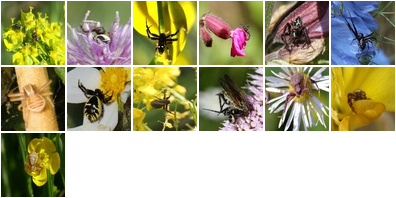

In [4]:
cls = 5
itorch.image(vis[cls])

In [3]:
local input_preprocess = {}
if opt.standardize then
   table.insert(input_preprocess, dp.Standardize())
end
if opt.zca then
   table.insert(input_preprocess, dp.ZCA())
end
if opt.lecunlcn then
   table.insert(input_preprocess, dp.GCN())
   table.insert(input_preprocess, dp.LeCunLCN{progress=false})
end


In [4]:
datasource = dp.Insects{input_preprocess = input_preprocess, labels_kind="order"}

In [5]:
--[[Model]]--

function dropout(depth)
   return opt.dropout and (opt.dropoutProb[depth] or 0) > 0 and nn.Dropout(opt.dropoutProb[depth])
end

cnn = dp.Sequential()
inputSize = datasource:imageSize('c')
height, width = datasource:imageSize('h'), datasource:imageSize('w')
depth = 1
for i=1,opt.channelSize do
    local conv = dp.Convolution2D{
        input_size = inputSize, 
        padding = opt.padding[i],
        kernel_size = {opt.kernelSize[i], opt.kernelSize[i]},
        kernel_stride = {opt.kernelStride[i], opt.kernelStride[i]},
        pool_size = {opt.poolSize[i], opt.poolSize[i]},
        pool_stride = {opt.poolStride[i], opt.poolStride[i]},
        output_size = opt.channelSize[i], 
        transfer = nn[opt.activation](),
        dropout = dropout(depth),
        sparse_input_preprocessinit = opt.sparse_init
   }
   cnn:add(conv)

   inputSize, height, width = conv:outputSize(height, width, 'bchw')
   depth = depth + 1
end

inputSize = inputSize*height*width
print("input to first Neural layer has: "..inputSize.." neurons")

for i,hiddenSize in ipairs(opt.hiddenSize) do
   local dense = dp.Neural{
      input_size = inputSize, 
      output_size = hiddenSizeLogSoftMax,
      transfer = nn[opt.activation](),
      dropout = dropout(depth),
      sparse_init = opt.sparse_init
   }
   cnn:add(dense)
   inputSize = hiddenSize
   depth = depth + 1
end

cnn:add(
   dp.Neural{
      input_size = inputSize, 
      output_size = (datasource:classes()),
      transfer = nn.LogSoftMax(),
      dropout = dropout(depth),
      sparse_init = opt.sparse_init
   }
)


input to first Neural layer has: 2048 neurons	


In [6]:
--[[Propagators]]--
train = dp.Optimizer{
   loss = dp.NLL(),
   visitor = { -- the ordering here is important:
      dp.Momentum{momentum_factor = opt.momentum},
      dp.Learn{
            learning_rate = opt.learningRate,
            observer = {dp.AdaptiveLearningRate{}}
      },
      dp.MaxNorm{max_out_norm = opt.maxOutNorm},
      dp.WeightDecay{wd_factor = opt.weight_decay_factor}
   },
   feedback = dp.Confusion(),
   sampler = dp.ShuffleSampler{batch_size = opt.batchSize},
   progress = false
}
valid = dp.Evaluator{
   loss = dp.NLL(),
   feedback = dp.Confusion(),  
   sampler = dp.Sampler{}
}
test = dp.Evaluator{
   loss = dp.NLL(),
   feedback = dp.Confusion(),
   sampler = dp.Sampler{}
}

In [7]:
--[[Experiment]]--
xp = dp.Experiment{
   model = cnn,
   optimizer = train,
   validator = valid,
   tester = test,
   observer = {
      dp.FileLogger(),
      dp.SaveReport(),
      dp.EarlyStopper{
         error_report = {'validator','feedback','confusion','accuracy'},
         maximize = true,
         max_epochs = opt.maxTries
      }
   },
   random_seed = os.time(),
   max_epoch = opt.maxEpoch
}

--[[GPU or CPU]]--
if opt.cuda then
   require 'cutorch'
   require 'cunn'
   cutorch.setDevice(opt.useDevice)
   xp:cuda()
end


In [8]:
xp:run(datasource)

FileLogger: log will be written to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1/log	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0	
==> epoch # 1 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4669814487792 ms	
==> epoch duration = 44.086136102676 s	
==> example speed = 288.43534780151 examples/s	
==> batch speed = 2.2909696546046 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 1.1289849079848	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.1141117181319	


llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 1.1079771839511	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.59908776344763	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.60323950306652	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.60663730732935	


==> epoch # 2 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4535932780887 ms	
==> epoch duration = 43.915892124176 s	
==> example speed = 289.55349384784 examples/s	
==> batch speed = 2.2998508083227 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 1.1136371342125	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.1117730127001	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 1.106226335366	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.59916640452973	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.60323950306652	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.60663730732935	


==> epoch # 3 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4433897466321 ms	
==> epoch duration = 43.786144018173 s	
==> example speed = 290.41150540048 examples/s	
==> batch speed = 2.3066657789752 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 1.1012271741588	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.1008645424323	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 1.0924812770745	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.59893048128342	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.60323950306652	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.60663730732935	


==> epoch # 4 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4392208151564 ms	
==> epoch duration = 43.733131885529 s	
==> example speed = 290.76353445905 examples/s	
==> batch speed = 2.309461857531 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 1.0887368125299	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.0839413219999	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 1.0766946796015	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.59877319911922	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.60323950306652	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.60663730732935	


==> epoch # 5 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4346285763309 ms	
==> epoch duration = 43.674736976624 s	
==> example speed = 291.15229719199 examples/s	
==> batch speed = 2.3125497024529 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 1.0833482474004	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.1008161321003	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 1.0922897703507	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.59861591695502	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.60323950306652	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.60663730732935	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 6 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4963849506576 ms	
==> epoch duration = 44.460031032562 s	
==> example speed = 286.00969690477 examples/s	
==> batch speed = 2.2717033176614 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 1.0734423516906	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.071264888547	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 1.0634158371979	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.59869455803712	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.60323950306652	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.60663730732935	


==> epoch # 7 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4944344219377 ms	
==> epoch duration = 44.43522810936 s	
==> example speed = 286.16934223235 examples/s	
==> batch speed = 2.272971340474 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 1.0659695438391	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.0886515999369	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 1.0809425754474	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.59916640452973	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.59632017612832	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.59924504561183	


==> epoch # 8 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4753779601511 ms	
==> epoch duration = 44.192906141281 s	
==> example speed = 287.73848814893 examples/s	
==> batch speed = 2.2854346730924 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 1.0397793062455	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.1178836388152	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 1.1059683470202	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.6097829506134	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.60323950306652	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.60663730732935	


Learning rate = 0.07	
==> epoch # 9 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4704031191295 ms	
==> epoch duration = 44.129646062851 s	
==> example speed = 288.15096277658 examples/s	
==> batch speed = 2.2887108556491 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 1.0250746778026	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.0147200318735	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 1.0040191966207	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.61025479710601	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.62179587985532	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.62393834539163	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 10 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.5375953095632 ms	
==> epoch duration = 44.984061956406 s	
==> example speed = 282.67789628076 examples/s	
==> batch speed = 2.2452396606131 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.9992778823553	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 1.0027329749348	


llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.99229009455574	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.62055677886128	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.62682811762856	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.62739855300409	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 11 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 3.4500989346956 ms	
==> epoch duration = 43.871458053589 s	
==> example speed = 289.8467606084 examples/s	
==> batch speed = 2.3021801526776 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.99083098188422	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.99635860663686	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.98702161255478	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.62378106322743	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.62871520679352	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.6283422459893	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 12 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7337994816994 ms	
==> epoch duration = 22.04699420929 s	
==> example speed = 576.76796570492 examples/s	
==> batch speed = 4.5811233513838 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.98401679639528	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.99391316684241	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.98514811666028	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.62763447625039	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.62792891964145	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.63133060710915	


==> epoch # 13 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7325469404318 ms	
==> epoch duration = 22.031066894531 s	
==> example speed = 577.18493892624 examples/s	
==> batch speed = 4.5844352651424 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.97773131164749	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.98000963384913	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.96877397380747	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.63038691412394	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.63091681081931	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.63258886442277	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 14 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7343061493042 ms	
==> epoch duration = 22.053436994553 s	
==> example speed = 576.59946624832 examples/s	
==> batch speed = 4.5797850024442 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.96935334631053	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.97797888892309	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.96648565002227	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.62881409248191	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.63217487026262	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.63180245360176	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 15 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335909873144 ms	
==> epoch duration = 22.04434299469 s	
==> example speed = 576.83733205671 examples/s	
==> batch speed = 4.5816743109254 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.95988848400906	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.9706308294306	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.9596233954029	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.63345391632589	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.6238402264507	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.63243158225857	


==> epoch # 16 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7329252864925 ms	
==> epoch duration = 22.035877943039 s	
==> example speed = 577.05892330997 examples/s	
==> batch speed = 4.5834343546954 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.9509894711936	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.95693657176638	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.9517541786866	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.63597043095313	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.63374744456676	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.63479081472161	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 17 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7337047779999 ms	


==> epoch duration = 22.045789957047 s	
==> example speed = 576.79947168033 examples/s	
==> batch speed = 4.5813735954477 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.94295439808932	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.96114840306355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.94581164064815	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.63730732934885	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.63390470199717	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.63903743315508	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 18 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7339446215406 ms	
==> epoch duration = 22.04883980751 s	
==> example speed = 576.71968734013 examples/s	
==> batch speed = 4.5807398884361 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.92664773665665	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.97174317221123	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.96365639343317	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.64375589808116	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.6076427111181	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.6097829506134	


==> epoch # 19 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7328483760638 ms	
==> epoch duration = 22.034899950027 s	
==> example speed = 577.08453538879 examples/s	
==> batch speed = 4.5836377850163 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.92300812535857	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.93921007520841	


llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.93192626973223	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.64359861591695	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.63264664255386	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.6402956904687	


==> epoch # 20 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7328526321992 ms	
==> epoch duration = 22.034954071045 s	
==> example speed = 577.08311798614 examples/s	
==> batch speed = 4.5836265269424 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.90355979031307	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.9464146366264	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.9330810059463	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.64753067002202	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.6423966032395	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.6525636992765	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 21 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7350449731568 ms	
==> epoch duration = 22.062831878662 s	
==> example speed = 576.35393633662 examples/s	
==> batch speed = 4.5778348199118 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.89287438334796	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.92062160630966	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.90926827291115	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.65279962252281	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.6469570687215	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.66027052532243	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 22 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7334693405905 ms	
==> epoch duration = 22.042796134949 s	
==> example speed = 576.87781178717 examples/s	
==> batch speed = 4.5819958312759 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.87946969204614	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.89882657386948	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.88419855193132	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.6585404215162	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.659694920585	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.66766278703995	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 23 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7329354299693 ms	
==> epoch duration = 22.03600692749 s	
==> example speed = 577.05554558238 examples/s	
==> batch speed = 4.583407526252 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.8655067578769	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.8768179000483	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.86747911418709	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.66553947782321	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.66032395030665	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.66105693614344	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 24 for optimizer	


==> epoch size = 12716 examples	
==> batch duration = 1.7330149465779 ms	
==> epoch duration = 22.037018060684 s	
==> example speed = 577.02906831512 examples/s	
==> batch speed = 4.5831972239562 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.85209416784404	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.88326834522527	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.8866434594714	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.66978609625668	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.66236829690203	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.66514627241271	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 25 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7340485874907 ms	
==> epoch duration = 22.050161838531 s	
==> example speed = 576.6851097564 examples/s	
==> batch speed = 4.5804652473574 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.83428497241704	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.87507784376917	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.87581940454181	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.67945894935514	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.65010221732977	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.65287826360491	


==> epoch # 26 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7326101824787 ms	
==> epoch duration = 22.031871080399 s	
==> example speed = 577.16387108461 examples/s	
==> batch speed = 4.5842679285582 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.82847149333101	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.86850092009489	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.85770488890621	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.68252595155709	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.67259002987891	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.6767851525637	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 27 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7331308559563 ms	
==> epoch duration = 22.03849196434 s	
==> example speed = 576.99047741449 examples/s	
==> batch speed = 4.5828907061075 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.81570110690128	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.89203883338449	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.88096261955386	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.68512110726644	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.64334014782198	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.64910349166405	


==> epoch # 28 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7327895588978 ms	
==> epoch duration = 22.034152030945 s	
==> example speed = 577.10412373218 examples/s	
==> batch speed = 4.5837933703169 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.80243461763063	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.81469647816693	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.81028976084001	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.69471531928279	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.68878754521151	


llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.69565901226801	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 29 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.734873640271 ms	
==> epoch duration = 22.060653209686 s	
==> example speed = 576.41085597668 examples/s	
==> batch speed = 4.5782869183426 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.78039524349617	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.84049160302593	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.82412788309402	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.70077068260459	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.68265450542538	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.69314249764077	


==> epoch # 30 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7328946310681 ms	
==> epoch duration = 22.035488128662 s	
==> example speed = 577.06913165495 examples/s	
==> batch speed = 4.5835154370203 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.77584621104458	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.81692476341194	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.81155435312989	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.69754639823844	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.69083189180689	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.69974834853728	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 31 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7344968504184 ms	
==> epoch duration = 22.055861949921 s	
==> example speed = 576.53607140236 examples/s	
==> batch speed = 4.5792814730763 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.76920748623653	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.80329902076667	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.79719440245747	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.70399496697075	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.69948105047964	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.70305127398553	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 32 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7332481902963 ms	
==> epoch duration = 22.039983987808 s	
==> example speed = 576.95141734377 examples/s	
==> batch speed = 4.5825804617585 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.74908713070185	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.79869521983033	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.78880220885994	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.71162315193457	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.69319075326309	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.70541050644857	


==> epoch # 33 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7331111314875 ms	
==> epoch duration = 22.038241147995 s	
==> example speed = 576.99704412014 examples/s	
==> batch speed = 4.5829428638042 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.74024328151638	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.78937173328377	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.78610280736431	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.71610569361434	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.69838024846674	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.70210758100031	


==> epoch # 34 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7329674353574 ms	
==> epoch duration = 22.036413908005 s	
==> example speed = 577.04488820574 examples/s	
==> batch speed = 4.5833228773812 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.72876885178029	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.79102867055302	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.78602505138025	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.72098144070462	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.69853750589715	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.70478137779176	


Learning rate = 0.007	
==> epoch # 35 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336116680074 ms	
==> epoch duration = 22.044605970383 s	
==> example speed = 576.83045081795 examples/s	
==> batch speed = 4.5816196549712 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.67860316106192	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.77354849771163	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.77410693157764	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.73977665932683	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.70734392200031	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71296005033029	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 36 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7341645156186 ms	
==> epoch duration = 22.051635980606 s	
==> example speed = 576.64655861286 examples/s	
==> batch speed = 4.5801590452893 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.66704425976481	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76754957132883	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76637763924926	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.74567474048443	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71096084289983	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71673482227115	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 37 for optimizer	



==> epoch size = 12716 examples	


==> batch duration = 1.7341487097943 ms	
==> epoch duration = 22.051434993744 s	
==> example speed = 576.65181443328 examples/s	
==> batch speed = 4.5802007909533 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.65595832435205	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.77276497368805	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.77226846852403	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.74889902485058	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71284793206479	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71421830764391	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 38 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7353691519263 ms	
==> epoch duration = 22.066954135895 s	
==> example speed = 576.24626949833 examples/s	
==> batch speed = 4.5769796492082 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.65121339425589	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76891035005569	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76261909680569	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75503302925448	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.70529957540494	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.70997168921044	


==> epoch # 39 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7333678870728 ms	
==> epoch duration = 22.041506052017 s	
==> example speed = 576.91157627753 examples/s	
==> batch speed = 4.5822640141578 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.65401112226597	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76591544212981	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76641126613115	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75125825731362	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.70986004088693	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.7131173324945	


==> epoch # 40 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7331778796899 ms	
==> epoch duration = 22.039089918137 s	
==> example speed = 576.97482279137 examples/s	
==> batch speed = 4.5827663653609 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.64804518043751	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76613458747813	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76691531033476	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75259515570934	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71190438748231	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71484743630072	


Learning rate = 0.0007	
==> epoch # 41 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7331893731304 ms	
==> epoch duration = 22.039236068726 s	
==> example speed = 576.97099665103 examples/s	
==> batch speed = 4.5827359752874 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63734259015079	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76378980101344	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76070693672433	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75550487574709	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71127535776065	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71531928279333	


==> epoch # 42 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7330383646972 ms	
==> epoch duration = 22.03731584549 s	
==> example speed = 577.02127106386 examples/s	
==> batch speed = 4.5831352923442 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63978345068737	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76390585983336	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76219840763536	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75676313306071	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71253341720396	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71579112928594	


==> epoch # 43 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7333258882038 ms	
==> epoch duration = 22.0409719944 s	
==> example speed = 576.92555497238 examples/s	
==> batch speed = 4.5823750434265 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63988068955767	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76311970838755	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76099694103292	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75912236552375	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71174713005189	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71500471846493	


Learning rate = 7e-05	
==> epoch # 44 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.733281770642 ms	
==> epoch duration = 22.040410995483 s	
==> example speed = 576.94023957202 examples/s	
==> batch speed = 4.5824916795198 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.64351920574462	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.7632225002671	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.7614008962133	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75684177414281	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71269067463438	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71500471846493	


==> epoch # 45 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7331902168576 ms	
==> epoch duration = 22.039246797562 s	
==> example speed = 576.97071577813 examples/s	
==> batch speed = 4.5827337443843 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63841065244128	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76332625271032	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76164940921117	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75684177414281	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71316244692562	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71516200062913	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 46 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7342511007868 ms	
==> epoch duration = 22.052736997604 s	
==> example speed = 576.61776864166 examples/s	
==> batch speed = 4.5799303737659 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.6389991359849	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76333334912179	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160130639726	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75676313306071	


llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71316244692562	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71531928279333	


==> epoch # 47 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7329493608442 ms	
==> epoch duration = 22.036184072495 s	
==> example speed = 577.05090673444 examples/s	
==> batch speed = 4.5833706810458 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63785148921741	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76337277372783	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76154268728219	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75967285309846	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71347696178644	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 48 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335097457523 ms	
==> epoch duration = 22.043309926987 s	
==> example speed = 576.86436574719 examples/s	
==> batch speed = 4.5818890327514 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.64061471178176	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76326523500711	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76155227179907	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75762818496383	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71379147664727	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 49 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7349417384371 ms	
==> epoch duration = 22.061519145966 s	
==> example speed = 576.38823128485 examples/s	
==> batch speed = 4.5781072160876 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63964336753341	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76326624408684	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76156038280251	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76187480339729	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71531928279333	


SaveToFile: saving to /home/gridcl/mehdicherti/save/llrgrcl02.in2p3.fr:1425184418:1.dat	


==> epoch # 50 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7346781392861 ms	
==> epoch duration = 22.058167219162 s	
==> example speed = 576.47581839681 examples/s	
==> batch speed = 4.5788028985591 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63918840493297	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76329372975787	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76150912518919	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76053790500157	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71516200062913	


==> epoch # 51 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7345850105442 ms	
==> epoch duration = 22.05698299408 s	
==> example speed = 576.50676900885 examples/s	
==> batch speed = 4.579048731511 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63453990750228	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76328846850209	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.7614798706708	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.7558194400755	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71363421921686	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71516200062913	


==> epoch # 52 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7333416190302 ms	
==> epoch duration = 22.041172027588 s	
==> example speed = 576.92031912296 examples/s	
==> batch speed = 4.5823334563871 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.6363087082976	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76326317072176	


llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76159142121348	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76006605850897	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-06	
==> epoch # 53 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7334054048124 ms	
==> epoch duration = 22.041983127594 s	
==> example speed = 576.89908963232 examples/s	
==> batch speed = 4.5821648358654 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63673671897701	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76326717401866	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160357321121	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75904372444165	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 54 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7333114885916 ms	
==> epoch duration = 22.040788888931 s	
==> example speed = 576.93034782371 examples/s	
==> batch speed = 4.5824131118429 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63858102967001	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.7632658821004	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76159572339762	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75739226171752	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 55 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.733484658928 ms	
==> epoch duration = 22.042990922928 s	
==> example speed = 576.87271407319 examples/s	
==> batch speed = 4.5819553414117 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63529013193377	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327133553641	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160380384875	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75817867253853	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	

Learning rate = 7e-07	
==> epoch # 56 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7333792867658 ms	
==> epoch duration = 22.041651010513 s	
==> example speed = 576.90778217724 examples/s	
==> batch speed = 4.5822338785704 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63998200400571	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327068433762	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.7616025034869	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75754954388172	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 57 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7333678683233 ms	
==> epoch duration = 22.041505813599 s	
==> example speed = 576.91158251787 examples/s	
==> batch speed = 4.5822640637232 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63755151341643	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76326950220851	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160100911464	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75715633847122	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 58 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335124269301 ms	
==> epoch duration = 22.043344020844 s	
==> example speed = 576.86347352635 examples/s	
==> batch speed = 4.5818819460649 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63702556836826	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327045218039	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160118896917	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75707769738912	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-08	
==> epoch # 59 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7334065672811 ms	
==> epoch duration = 22.041997909546 s	
==> example speed = 576.8987027484 examples/s	
==> batch speed = 4.5821617629434 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63604660461105	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327042603833	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160119301906	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75888644227745	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 60 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336103180438 ms	
==> epoch duration = 22.044588804245 s	
==> example speed = 576.83089999625 examples/s	
==> batch speed = 4.5816232226818 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.64088406857453	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327039959632	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160114690468	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76077382824788	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 61 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335104582331 ms	
==> epoch duration = 22.043318986893 s	
==> example speed = 576.86412865327 examples/s	
==> batch speed = 4.5818871495738 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63710851489691	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035443589	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110213089	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76085246932998	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-09	
==> epoch # 62 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7333227570382 ms	
==> epoch duration = 22.040932178497 s	
==> example speed = 576.92659716114 examples/s	
==> batch speed = 4.5823833212705 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63607987229949	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035530761	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.7616010998247	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76085246932998	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 63 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7334422850691 ms	
==> epoch duration = 22.042452096939 s	
==> example speed = 576.88681568081 examples/s	
==> batch speed = 4.5820673469457 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.6402932703495	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035377039	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110139028	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75660585089651	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 64 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335429511081 ms	
==> epoch duration = 22.04373216629 s	
==> example speed = 576.85331612972 examples/s	
==> batch speed = 4.58180126841 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63898444178532	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035315175	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110154028	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75644856873231	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-10	
==> epoch # 65 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336988906584 ms	
==> epoch duration = 22.045715093613 s	
==> example speed = 576.80143039153 examples/s	
==> batch speed = 4.5813891529998 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.6391757299837	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035406096	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.7616011014934	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75723497955332	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 66 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335747877507 ms	


==> epoch duration = 22.044137001038 s	
==> example speed = 576.8427223711 examples/s	
==> batch speed = 4.5817171248412 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63446433802339	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035388287	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110304961	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76116703365838	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 67 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336685164764 ms	
==> epoch duration = 22.045328855515 s	
==> example speed = 576.81153605559 examples/s	
==> batch speed = 4.5814694197558 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63869160862323	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035433279	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110375272	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75566215791129	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-11	
==> epoch # 68 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336649165734 ms	
==> epoch duration = 22.045283079147 s	
==> example speed = 576.8127337874 examples/s	
==> batch speed = 4.5814789330392 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63871258015376	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035376102	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110358397	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75699905630701	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 69 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335839187548 ms	
==> epoch duration = 22.044253110886 s	
==> example speed = 576.83968406808 examples/s	
==> batch speed = 4.5816929923621 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63368170369755	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035377976	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110349022	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75935828877005	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 70 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7334080672407 ms	
==> epoch duration = 22.042016983032 s	
==> example speed = 576.89820354411 examples/s	
==> batch speed = 4.5821577978889 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63625954176859	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76030198175527	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-12	
==> epoch # 71 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7334694905865 ms	
==> epoch duration = 22.042798042297 s	
==> example speed = 576.87776187032 examples/s	
==> batch speed = 4.5819954347989 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63850044590585	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	


llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75652720981441	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 72 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7340858802363 ms	
==> epoch duration = 22.050636053085 s	
==> example speed = 576.67270773447 examples/s	
==> batch speed = 4.5803667412065 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63693397488186	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75676313306071	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 73 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.733520526712 ms	
==> epoch duration = 22.04344701767 s	
==> example speed = 576.86077816265 examples/s	
==> batch speed = 4.5818605374668 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63799381842962	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	


llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75511167033658	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-13	
==> epoch # 74 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336404484824 ms	
==> epoch duration = 22.044971942902 s	
==> example speed = 576.82087475255 examples/s	
==> batch speed = 4.5815435946845 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63932796604474	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75880780119534	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 75 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7338279434329 ms	
==> epoch duration = 22.047356128693 s	
==> example speed = 576.75849774347 examples/s	
==> batch speed = 4.5810481497397 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.6409358323211	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75676313306071	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 76 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7334890650593 ms	
==> epoch duration = 22.043046951294 s	
==> example speed = 576.87124779515 examples/s	
==> batch speed = 4.5819436951329 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.64257304283218	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.7560553633218	


llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-14	
==> epoch # 77 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7337455956506 ms	
==> epoch duration = 22.046308994293 s	
==> example speed = 576.78589206436 examples/s	
==> batch speed = 4.5812657359626 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.6381435475988	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75841459578484	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 78 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7333430252423 ms	
==> epoch duration = 22.041189908981 s	
==> example speed = 576.91985108383 examples/s	
==> batch speed = 4.5823297388697 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.637024858578	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76156023906889	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 79 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7334403913701 ms	
==> epoch duration = 22.042428016663 s	
==> example speed = 576.88744590149 examples/s	
==> batch speed = 4.5820723526306 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63886537034206	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75566215791129	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-15	
==> epoch # 80 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7337505455173 ms	
==> epoch duration = 22.046371936798 s	
==> example speed = 576.78424533768 examples/s	
==> batch speed = 4.5812526564255 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.64209629785587	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75802139037433	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 81 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7337069154423 ms	
==> epoch duration = 22.045817136765 s	
==> example speed = 576.79876055918 examples/s	
==> batch speed = 4.5813679471907 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.6405796198237	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	


llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75802139037433	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 82 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335751814901 ms	
==> epoch duration = 22.044142007828 s	
==> example speed = 576.84259135532 examples/s	
==> batch speed = 4.5817160842157 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63992252306073	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75912236552375	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-16	
==> epoch # 83 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335136081483 ms	
==> epoch duration = 22.043359041214 s	
==> example speed = 576.8630804509 examples/s	
==> batch speed = 4.5818788239652 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63671408890365	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75723497955332	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 84 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336672040118 ms	
==> epoch duration = 22.045312166214 s	
==> example speed = 576.81197272807 examples/s	
==> batch speed = 4.5814728881358 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63688037390508	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75920100660585	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 85 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7337124840423 ms	
==> epoch duration = 22.045887947083 s	
==> example speed = 576.79690790966 examples/s	
==> batch speed = 4.58135323206 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63981213163058	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.7560553633218	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-17	
==> epoch # 86 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335002397583 ms	
==> epoch duration = 22.043189048767 s	
==> example speed = 576.86752909789 examples/s	
==> batch speed = 4.5819141584529 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63639048805923	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	


llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75802139037433	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 87 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335720503244 ms	
==> epoch duration = 22.044102191925 s	
==> example speed = 576.84363324436 examples/s	
==> batch speed = 4.5817243596792 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63638892844342	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75747090279962	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 88 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7337200400889 ms	
==> epoch duration = 22.04598402977 s	
==> example speed = 576.79439406419 examples/s	
==> batch speed = 4.5813332652157 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.638612297017	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75794274929223	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-18	
==> epoch # 89 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7339845204661 ms	
==> epoch duration = 22.049347162247 s	
==> example speed = 576.70641703953 examples/s	
==> batch speed = 4.5806344857654 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63615356079622	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75990877634476	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 90 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336818286179 ms	
==> epoch duration = 22.045498132706 s	
==> example speed = 576.8071069864 examples/s	
==> batch speed = 4.5814342407696 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63651090753963	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75723497955332	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 91 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7338411430774 ms	
==> epoch duration = 22.047523975372 s	
==> example speed = 576.75410691033 examples/s	
==> batch speed = 4.5810132744529 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63516244508815	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75872916011324	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-19	
==> epoch # 92 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7335113957079 ms	
==> epoch duration = 22.043330907822 s	
==> example speed = 576.86381668788 examples/s	
==> batch speed = 4.5818846717109 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63456402583087	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75778546712803	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 93 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7345462365884 ms	
==> epoch duration = 22.056489944458 s	
==> example speed = 576.51965621099 examples/s	
==> batch speed = 4.5791510913266 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63778967945858	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.76108839257628	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 94 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336556355733 ms	
==> epoch duration = 22.045165061951 s	
==> example speed = 576.81582171265 examples/s	
==> batch speed = 4.5815034596553 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.64000366011311	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75574079899339	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-20	
==> epoch # 95 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7334927024613 ms	
==> epoch duration = 22.043093204498 s	
==> example speed = 576.87003734145 examples/s	
==> batch speed = 4.5819340808026 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63519588426416	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75959421201636	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 96 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7344402269434 ms	
==> epoch duration = 22.055141925812 s	
==> example speed = 576.55489331121 examples/s	
==> batch speed = 4.5794309707795 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63874831650852	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75739226171752	


llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 97 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336075056195 ms	
==> epoch duration = 22.044553041458 s	
==> example speed = 576.83183578663 examples/s	
==> batch speed = 4.5816306554301 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.64163720662599	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75534759358289	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-21	
==> epoch # 98 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336178928398 ms	
==> epoch duration = 22.044685125351 s	
==> example speed = 576.82837961595 examples/s	
==> batch speed = 4.5816032039329 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63699996295628	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75857187794904	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 99 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.7336870034786 ms	
==> epoch duration = 22.045563936234 s	
==> example speed = 576.80538528208 examples/s	
==> batch speed = 4.5814205657039 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.63999840744676	
llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75770682604593	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


==> epoch # 100 for optimizer	



==> epoch size = 12716 examples	
==> batch duration = 1.733543326098 ms	
==> epoch duration = 22.043736934662 s	
==> example speed = 576.85319134821 examples/s	
==> batch speed = 4.5818002773017 batches/s	


llrgrcl02.in2p3.fr:1425184418:1:optimizer:loss avgError 0.6346044939207	


llrgrcl02.in2p3.fr:1425184418:1:validator:loss avgError 0.76327035357355	
llrgrcl02.in2p3.fr:1425184418:1:tester:loss avgError 0.76160110362147	
llrgrcl02.in2p3.fr:1425184418:1:optimizer:confusion accuracy = 0.75778546712803	
llrgrcl02.in2p3.fr:1425184418:1:validator:confusion accuracy = 0.71394873407769	
llrgrcl02.in2p3.fr:1425184418:1:tester:confusion accuracy = 0.71547656495753	


Learning rate = 7e-22	
found maxima : 0.71394873407769 at epoch 49	



Learning rate = 7e-18	
found maxima : 0.60842899827017 at epoch 5	



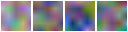

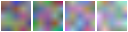

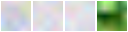

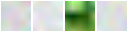

In [10]:
--[[Visualize weights]]--

require 'image'
k = 1
conv_filters = cnn:get(1)._param_modules[k].weight
conv_filters = torch.reshape(conv_filters, conv_filters:size(1), 
                             datasource:imageSize('c'), opt.kernelSize[k], 
                             opt.kernelSize[k]):float()

for y=1, 4 do
    row = {}
    for x=1, 4 do
        f = image.scale(conv_filters[x*y], 30, 30)
        --f = torch.reshape(f, 1, f:size(1), f:size(2))
        row[x] = f
    end
    itorch.image(row)
end

In [9]:
--[[Plot learning curves]]--

reports = (xp._observer._observers[2]._reports)

train_error = {}
valid_error = {}
test_error = {}
for k=1,#(reports) do
    train_error[k] = 100*(1-reports[k].optimizer.feedback.confusion.accuracy)
    valid_error[k] = 100*(1-reports[k].validator.feedback.confusion.accuracy)
    test_error[k] = 100*(1-reports[k].tester.feedback.confusion.accuracy)
    
end
Plot = require 'itorch.Plot'


epochs = torch.range(1,#reports)
plot = Plot()
plot = plot:line(epochs, train_error,'red','train error (%)')
plot = plot:line(epochs, valid_error,'blue','valid error (%)')
    plot = plot:line(epochs, test_error,'green','test error (%)')
plot = plot:legend(true):title('Error')
plot:draw()


In [2]:
print(train_error)
print(valid_error)
print(test_error)

{
  1 : 40.146272412708
  2 : 39.682290028311
  3 : 39.682290028311
  4 : 39.682290028311
  5 : 39.682290028311
  6 : 39.682290028311
  7 : 39.65083359547
  8 : 39.737338785782
  9 : 39.690154136521
  10 : 39.698018244731
  11 : 39.61151305442
  12 : 39.391318024536
  13 : 39.0531613715
  14 : 38.832966341617
  15 : 38.628499528154
  16 : 38.046555520604
  17 : 38.148788927336
  18 : 37.983642654923
  19 : 37.849952815351
  20 : 37.315193457062
  21 : 37.260144699591
  22 : 36.929852154766
  23 : 36.678200692042
  24 : 36.60742371815
  25 : 36.072664359862
  26 : 36.167033658383
  27 : 35.624410191884
  28 : 35.39635105379
  29 : 34.72790185593
  30 : 34.083044982699
  31 : 33.854985844605
  32 : 33.626926706511
  33 : 32.982069833281
  34 : 32.486631016043
  35 : 31.881094683863
  36 : 32.061969172696
  37 : 31.08681975464
  38 : 30.559924504561
  39 : 30.48128342246
  40 : 28.711859075181
  41 : 28.271469015414


  42 : 28.326517772885
  43 : 28.03554576911
  44 : 28.03554576911
  45 : 27.972632903429
  46 : 27.256999056307
  47 : 27.477194086191
  48 : 27.256999056307
  49 : 27.367096571249
  50 : 27.131173324945
  51 : 26.910978295061
  52 : 26.879521862221
  53 : 27.233406731677
  54 : 26.918842403271
  55 : 27.312047813778
  56 : 27.068260459264
  57 : 27.209814407046
  58 : 27.272727272727
  59 : 26.620006291287
  60 : 27.41428122051
  61 : 27.091852783894
  62 : 27.233406731677
  63 : 26.85592953759
  64 : 26.627870399497
  65 : 27.013211701793
  66 : 26.887385970431
  67 : 27.178357974206
  68 : 27.146901541365
  69 : 27.060396351054
  70 : 27.052532242844
  71 : 26.83233721296
  72 : 27.115445108525
  73 : 26.785152563699
  74 : 26.580685750236
  75 : 27.201950298836
  76 : 27.201950298836
  77 : 26.918842403271
  78 : 26.934570619692
  79 : 26.83233721296
  80 : 26.926706511482
  81 : 26.84806542938
  82 : 26.745832022649
  83 : 27.091852783894
  84 : 26.942434727902
  85 : 26.95029883

97 : 27.343504246618
}
{
  1 : 40.320805158044
  2 : 40.320805158044
  3 : 40.320805158044
  4 : 40.320805158044
  5 : 40.320805158044
  6 : 40.320805158044
  7 : 40.320805158044
  8 : 40.320805158044
  9 : 40.320805158044
  10 : 40.305079415002
  11 : 40.257902185878
  12 : 39.959113068092
  13 : 39.628872464224
  14 : 39.220003145149
  15 : 40.226450699796
  16 : 38.528070451329
  17 : 38.150652618336
  18 : 38.370813020915
  19 : 38.103475389212
  20 : 37.946217958799
  21 : 39.267180374273
  22 : 37.254285264979
  23 : 37.458719924516
  24 : 37.081302091524
  25 : 39.141374429942
  26 : 37.977669444881
  27 : 36.986947633276
  28 : 36.122031766001
  29 : 36.68815851549
  30 : 35.493002044347
  31 : 36.153483252084
  32 : 38.449441736122
  33 : 34.863972322692
  34 : 34.596634690989
  35 : 34.266394087121
  36 : 33.432929705929
  37 : 35.257115898726
  38 : 35.445824815223
  39 : 33.621638622425
  40 : 32.253498977827
  41 : 32.033338575248
  42 : 32.159144519579
  43 : 32.001887089

 53 : 31.750275200503
  54 : 31.781726686586
  55 : 31.750275200503
  56 : 31.750275200503
  57 : 31.750275200503
  58 : 31.734549457462
  59 : 31.734549457462
  60 : 31.734549457462
  61 : 31.734549457462
  62 : 31.734549457462
  63 : 31.734549457462
  64 : 31.734549457462
  65 : 31.734549457462
  66 : 31.734549457462
  67 : 31.734549457462
  68 : 31.734549457462
  69 : 31.734549457462
  70 : 31.734549457462
  71 : 31.734549457462
  72 : 31.734549457462
  73 : 31.734549457462
  74 : 31.734549457462
  75 : 31.734549457462
  76 : 31.734549457462
  77 : 31.734549457462
  78 : 31.734549457462
  79 : 31.734549457462
  80 : 31.734549457462
  81 : 31.734549457462
  82 : 31.734549457462
  83 : 31.734549457462
  84 : 31.734549457462
  85 : 31.734549457462
  86 : 31.734549457462
  87 : 31.734549457462
  88 : 31.734549457462
  89 : 31.734549457462
  90 : 31.734549457462
  91 : 31.734549457462
  92 : 31.734549457462
  93 : 31.734549457462
  94 : 31.734549457462
  95 : 31.734549457462
  96 : 31.73

  9 : 39.509279647688
  10 : 39.540736080528
  11 : 39.462094998427
  12 : 38.911607423718
  13 : 38.140924819126
  14 : 37.653350110098
  15 : 38.801509908776
  16 : 37.087134318968
  17 : 36.725385341302
  18 : 37.574709027996
  19 : 37.024221453287
  20 : 36.58383139352
  21 : 37.275872916011
  22 : 36.646744259201
  23 : 36.552374960679
  24 : 35.687323057565
  25 : 39.068889587921
  26 : 37.150047184649
  27 : 36.709657124882
  28 : 34.75935828877
  29 : 34.869455803712
  30 : 34.586347908147
  31 : 35.608681975464
  32 : 37.637621893677
  33 : 34.067316766279
  34 : 33.658383139352
  35 : 33.674111355772
  36 : 33.107895564643
  37 : 34.586347908147
  38 : 34.476250393205
  39 : 33.029254482542
  40 : 31.944007549544
  41 : 31.582258571878
  42 : 31.424976407675
  43 : 31.362063541994
  44 : 31.157596728531
  45 : 31.220509594212
  46 : 31.07895564643
  47 : 31.031770997169
  48 : 30.795847750865
  49 : 31.141868512111
  50 : 31.157596728531
  51 : 30.984586347908
  52 : 30.92167

62 : 30.874488832966
  63 : 30.874488832966
  64 : 30.874488832966
  65 : 30.874488832966
  66 : 30.874488832966
  67 : 30.874488832966
  68 : 30.874488832966
  69 : 30.874488832966
  70 : 30.874488832966
  71 : 30.874488832966
  72 : 30.874488832966
  73 : 30.874488832966
  74 : 30.874488832966
  75 : 30.874488832966
  76 : 30.874488832966
  77 : 30.874488832966
  78 : 30.874488832966
  79 : 30.874488832966
  80 : 30.874488832966
  81 : 30.874488832966
  82 : 30.874488832966
  83 : 30.874488832966
  84 : 30.874488832966
  85 : 30.874488832966
  86 : 30.874488832966
  87 : 30.874488832966
  88 : 30.874488832966
  89 : 30.874488832966
  90 : 30.874488832966
  91 : 30.874488832966
  92 : 30.874488832966
  93 : 30.874488832966
  94 : 30.874488832966
  95 : 30.874488832966
  96 : 30.874488832966
  97 : 30.874488832966
}
